# Creación del Dataset

Primero se va a hacer con los datos balanceados, es decir, la selección de datos más pequeños. Como ya han sido preprocesadas al ejecutar el otro código no se ha añadido esa parte al archivo.

Found 1782 files belonging to 9 classes.
Mapeo entre nombres de clases y etiquetas:
0: AK
1: Acne
2: BCC
3: DF
4: MEL
5: NV
6: SCC
7: SEK
8: VASC


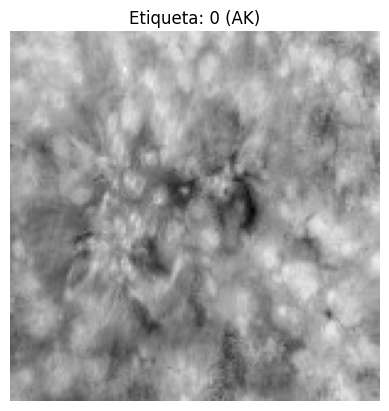

In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Ruta de la carpeta raíz donde están organizadas las imágenes por clase
ruta_dataset = '/content/drive/My Drive/imagenes/imagenes finales normalizadas'

# Crear el dataset desde las imágenes (aún no desagrupado)
raw_dataset = tf.keras.utils.image_dataset_from_directory(
    ruta_dataset,
    labels="inferred",       # TensorFlow infiere las etiquetas desde las carpetas
    label_mode="int",        # Etiquetas como enteros
    color_mode="grayscale",  # Las imágenes están en escala de grises
    image_size=(150, 150),
    shuffle=False,           # No mezclar para preservar el orden
    seed=42                  # Semilla para reproducibilidad
)

# Obtener nombres de las clases desde el dataset sin procesar
nombres_clases = raw_dataset.class_names

# Desagrupar las imágenes
dataset = raw_dataset.unbatch()

# Mostrar el mapeo entre nombres de clases y etiquetas
print("Mapeo entre nombres de clases y etiquetas:")
for i, nombre in enumerate(nombres_clases):
    print(f"{i}: {nombre}")

# Mostrar una de las imágenes del conjunto de entrenamiento
for imagen, etiqueta in dataset.take(1):
    plt.imshow(imagen.numpy().squeeze(), cmap="gray")  # Remover la dimensión extra del canal
    plt.title(f"Etiqueta: {etiqueta.numpy()} ({nombres_clases[etiqueta.numpy()]})")
    plt.axis("off")
    plt.show()

# Preparar datos en las variables X e y
Ambas variables son listas, en la X se han añadido las imágenes y en la y las etiquetas de las mismas.

In [32]:
#Preparar mis variables X (entradas) e y (etiquetas) separadas

X = []
y = []

for imagen, etiqueta in dataset:
  X.append(imagen)
  y.append(etiqueta)

Una vez creadas esas variables se dividen en un conjunto de entrenamiento y otro de prueba, dejando al primero con el 80% de los datos y el segundo con el 20% restante.

Se pide la forma de los conjuntos para asegurar que ha seleccionado correctamente los datos.

In [53]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,   # El 20% de los datos se usará para prueba
    random_state=42, # Para reproducibilidad
    stratify=y       # Asegurar que las clases estén balanceadas en la división
)

# Confirmar las formas de los conjuntos
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (1425, 150, 150, 1), y_train: (1425,)
X_test: (357, 150, 150, 1), y_test: (357,)


# Definición del modelo

Tres capas convolucionales para extraer características.
Capas de MaxPooling para reducir dimensiones.
Capas densas para clasificar en 9 clases.
Configura un optimizador (Adam) con una tasa de aprendizaje que disminuye automáticamente.

Compilar el modelo con la función de pérdida y la métrica de precisión.

In [54]:
import tensorflow as tf

modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(9, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
modeloCNN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Entrenamiento del modelo

Se realiza el entrenamiento del modelo aplicando EarlyStopping para evitar el sobreajuste.

In [55]:
from tensorflow.keras.callbacks import TensorBoard

In [56]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)

modeloCNN.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.15,  # Parte del entrenamiento se usará para validación
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.1567 - loss: 62.3527 - val_accuracy: 0.2944 - val_loss: 1.9705
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3517 - loss: 1.8727 - val_accuracy: 0.3879 - val_loss: 2.0358
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3732 - loss: 1.8558 - val_accuracy: 0.3879 - val_loss: 1.8774
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.4257 - loss: 1.6836 - val_accuracy: 0.3785 - val_loss: 1.9674
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4544 - loss: 1.5355 - val_accuracy: 0.3879 - val_loss: 1.9713
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4710 - loss: 1.5353 - val_accuracy: 0.3598 - val_loss: 1.9075
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5185 - loss: 1.3547 - val_accuracy: 0.4065 - val_loss: 1.7673
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.5857 - loss: 1.2458 - val_accuracy: 0.4159 - 

# Evaluación del modelo
Se usa el conjunto de pruebas.

In [57]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modeloCNN.evaluate(X_test, y_test)

print(f"Pérdida en prueba: {test_loss}")
print(f"Precisión en prueba: {test_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.4517 - loss: 3.9721
Pérdida en prueba: 3.3445258140563965
Precisión en prueba: 0.45378151535987854


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 513ms/step


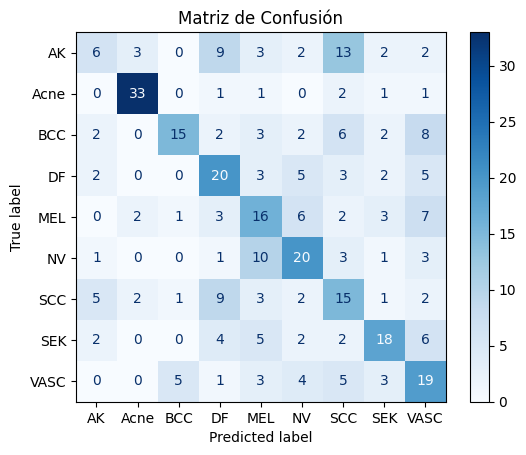

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predecir las etiquetas para el conjunto de prueba
y_pred_probs = modeloCNN.predict(X_test)  # Probabilidades predichas
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertir probabilidades a etiquetas

# Crear la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión como un gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=nombres_clases)
disp.plot(cmap="Blues", values_format="d")

plt.title("Matriz de Confusión")
plt.show()

# Creación de un modelo similar con más datos
Se usa la carpeta con todas las imágenes preprocesadas obtenidas con el archivo anterior.

Found 22992 files belonging to 9 classes.
Mapeo entre nombres de clases y etiquetas:
0: AK
1: Acne
2: BCC
3: DF
4: MEL
5: NV
6: SCC
7: SEK
8: VASC


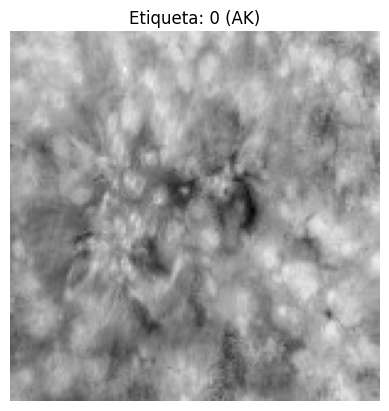

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Ruta de la carpeta raíz donde están organizadas las imágenes por clase
ruta_dataset = '/content/drive/My Drive/imagenes/todas las imagenes finales normalizadas'

# Crear el dataset desde las imágenes (aún no desagrupado)
raw_dataset = tf.keras.utils.image_dataset_from_directory(
    ruta_dataset,
    labels="inferred",       # TensorFlow infiere las etiquetas desde las carpetas
    label_mode="int",        # Etiquetas como enteros
    color_mode="grayscale",  # Las imágenes están en escala de grises
    image_size=(150, 150),
    shuffle=False,           # No mezclar para preservar el orden
    seed=42                  # Semilla para reproducibilidad
)

# Obtener nombres de las clases desde el dataset sin procesar
nombres_clases = raw_dataset.class_names

# Desagrupar las imágenes
dataset = raw_dataset.unbatch()

# Mostrar el mapeo entre nombres de clases y etiquetas
print("Mapeo entre nombres de clases y etiquetas:")
for i, nombre in enumerate(nombres_clases):
    print(f"{i}: {nombre}")

# Mostrar una de las imágenes del conjunto de entrenamiento
for imagen, etiqueta in dataset.take(1):
    plt.imshow(imagen.numpy().squeeze(), cmap="gray")  # Remover la dimensión extra del canal
    plt.title(f"Etiqueta: {etiqueta.numpy()} ({nombres_clases[etiqueta.numpy()]})")
    plt.axis("off")
    plt.show()

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from keras.callbacks import EarlyStopping

In [5]:
# Preparar las variables X (entradas) y y (etiquetas) separadas
X = []
y = []

for imagen, etiqueta in dataset:
  X.append(imagen)
  y.append(etiqueta)

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,   # El 20% de los datos se usará para prueba
    random_state=42, # Para reproducibilidad
    stratify=y       # Asegurar que las clases estén balanceadas en la división
)

# Convertir las listas a arrays de NumPy
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Calcular los pesos de clase
clases_unicas = np.unique(y_train)
pesos_clase = compute_class_weight('balanced', classes=clases_unicas, y=y_train)

# Crear un diccionario de pesos de clase
pesos_dict = dict(zip(clases_unicas, pesos_clase))
print(f"Pesos de clase: {pesos_dict}")

# Definir el modelo CNN
modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(9, activation='softmax')
])

# Definir el optimizador con tasa de aprendizaje decreciente
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
modeloCNN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)

Pesos de clase: {0: 2.9965786901270772, 1: 1.0067323481116583, 2: 1.0395049169209902, 3: 12.61522633744856, 4: 0.5324821955879798, 5: 0.29120357176783507, 6: 4.071049136786189, 7: 1.025422311423315, 8: 10.117161716171617}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Entrenar el modelo con pesos de clase
modeloCNN.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.15,  # Parte del entrenamiento se usará para validación
    epochs=100,
    callbacks=[early_stopping],
    class_weight=pesos_dict  # Aquí se pasan los pesos de clase
)



Epoch 1/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.0607 - loss: 9.1834 - val_accuracy: 0.0098 - val_loss: 2.1968
Epoch 2/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 800s 2s/step - accuracy: 0.0636 - loss: 2.1782 - val_accuracy: 0.0098 - val_loss: 2.1980
Epoch 3/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.0206 - loss: 2.2270 - val_accuracy: 0.0326 - val_loss: 2.1987
Epoch 4/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step - accuracy: 0.0410 - loss: 2.1890 - val_accuracy: 0.0098 - val_loss: 2.1987
Epoch 5/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.0274 - loss: 2.2057 - val_accuracy: 0.0098 - val_loss: 2.1976
Epoch 6/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 797s 2s/step - accuracy: 0.0216 - loss: 2.2411 - val_accuracy: 0.0098 - val_loss: 2.1968
Epoch 7/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.0804 - loss: 2.1931 - val_accuracy: 0.0098 - val_loss: 2.1968
Epoch 8/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.0224 - loss: 2.2238 - 

144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 433ms/step - accuracy: 0.0351 - loss: 2.1981
Pérdida en prueba: 2.198077440261841
Precisión en prueba: 0.03696455806493759
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 440ms/step


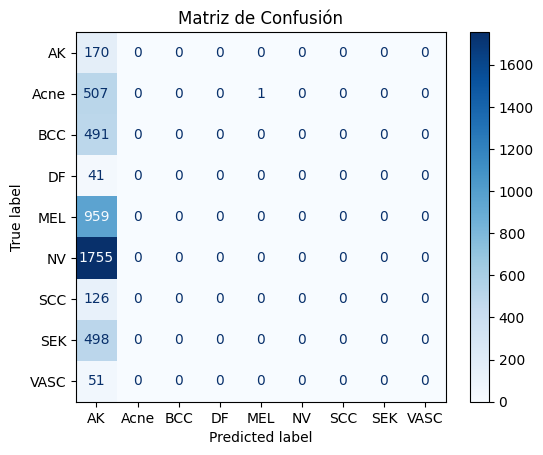

In [8]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modeloCNN.evaluate(X_test, y_test)
print(f"Pérdida en prueba: {test_loss}")
print(f"Precisión en prueba: {test_accuracy}")

# Predecir las etiquetas para el conjunto de prueba
y_pred_probs = modeloCNN.predict(X_test)  # Probabilidades predichas
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertir probabilidades a etiquetas

# Crear la matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusion = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión como un gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=nombres_clases)
disp.plot(cmap="Blues", values_format="d")

plt.title("Matriz de Confusión")
plt.show()